# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
pip install --upgrade category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [3]:
import category_encoders as ce
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import plotly.express as px
from scipy.linalg import svd

In [4]:
#read data from file
dfvehicles = pd.read_csv('data/vehicles.csv')
dfvehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
#checking missing values in the file
dfvehicles.isna().sum()

,0
id,0
region,0
price,0
year,1205
manufacturer,17646
model,5277
condition,174104
cylinders,177678
fuel,3013
odometer,4400


In [6]:
#Show all columns
pd.set_option('display.max_columns', None)
dfvehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [7]:
dfvehicles.nunique()
#dfvehicles.describe()

,0
id,426880
region,404
price,15655
year,114
manufacturer,42
model,29649
condition,6
cylinders,8
fuel,5
odometer,104870


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

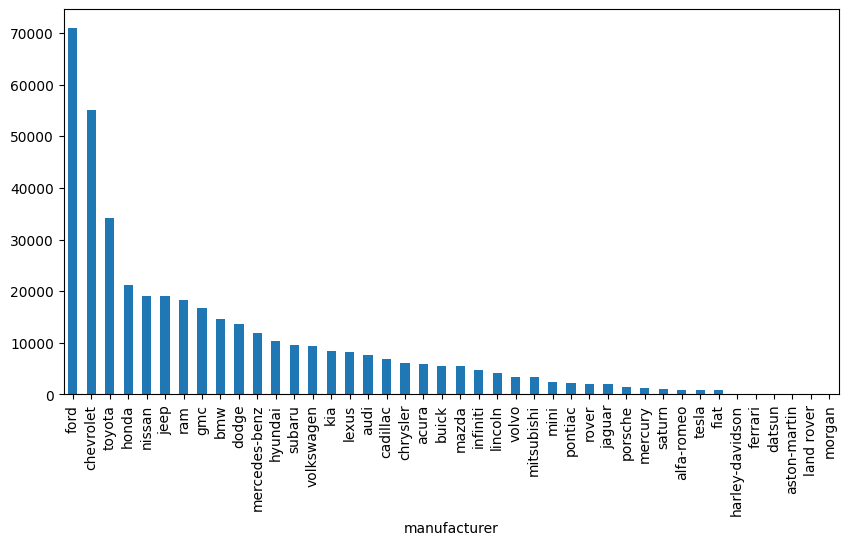

In [8]:
#plot a chart ti show distribution of manufactures
plt.figure(figsize=(10,5))
dfvehicles['manufacturer'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [9]:
# remove outliers all cars with price > 100000
car_data = dfvehicles.drop(dfvehicles[dfvehicles['price']>100000].index)

#consider 10 manufacture models by count
car_data['manufacturer'].value_counts().head(10)
car_data= car_data[car_data['manufacturer'].isin(car_data['manufacturer'].value_counts().head(10).index)]

In [10]:
# For each manufacturer and model, fuel_type, list average price
car_avg_price = car_data.groupby(['manufacturer', 'model', 'year', 'fuel'])['price'].mean().reset_index()
car_avg_price


,manufacturer,model,year,fuel,price
0,bmw,- 328i - convertible,1997.0,gas,7200.000000
1,bmw,1 series,2008.0,gas,8799.000000
2,bmw,1 series,2009.0,gas,13995.000000
3,bmw,1 series,2011.0,gas,17631.333333
4,bmw,1 series,2012.0,gas,12487.000000
...,...,...,...,...,...
40264,toyota,yaris sedan,2010.0,gas,6125.000000
40265,toyota,yaris sedan,2019.0,gas,14797.400000
40266,toyota,yaris sedan le,2007.0,gas,3600.000000
40267,toyota,yaris sedan le,2010.0,gas,5450.000000


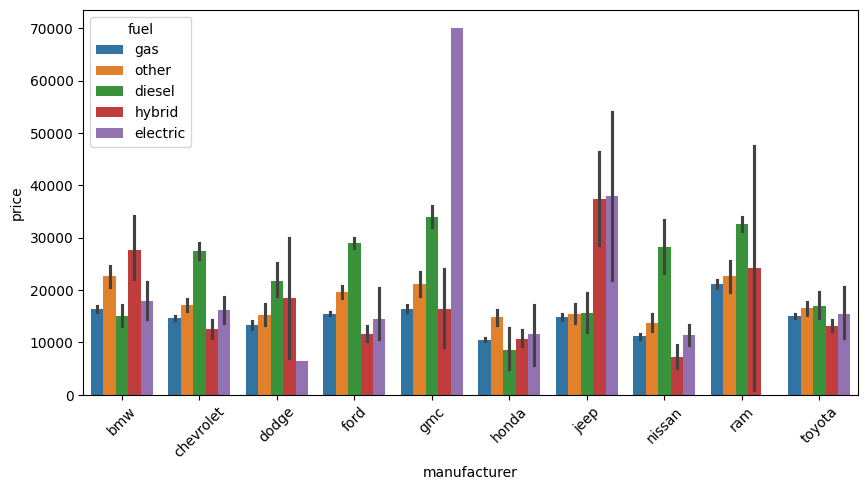

In [11]:
# plot average price for fuel type, for each manufacturer
plt.figure(figsize=(10,5))
sns.barplot(x='manufacturer', y='price',hue='fuel',data=car_avg_price)
plt.xticks(rotation=45)
plt.show()



*   Diesel powered vehicles are priced higher than their gas
*   Comparing type of vechicles EV for GMC ,Jeep are higher price than others.



In [12]:
#compare with the type of the vechicles
car_data['type'].value_counts()

#Average price of the car by type
car_type_avg_price = car_data.groupby(['manufacturer', 'model', 'year', 'type'])['price'].mean().reset_index()
car_type_avg_price

#Consider only 5 types
car_type_avg_price= car_type_avg_price[car_type_avg_price['type'].isin(car_type_avg_price['type'].value_counts().head(5).index)]

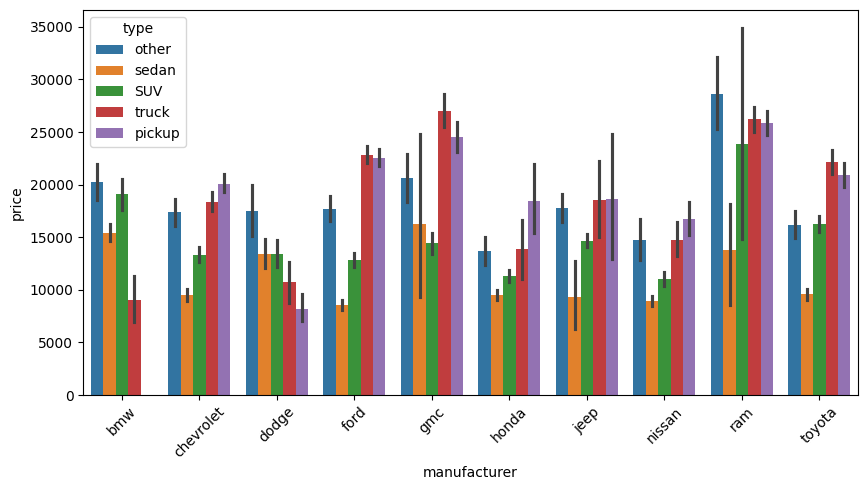

In [13]:
#plot graph for average type of cars
plt.figure(figsize=(10,5))
sns.barplot(x='manufacturer', y='price',hue='type',data=car_type_avg_price)
plt.xticks(rotation=45)
plt.show()


        
*   Sedan is lower compare with other types


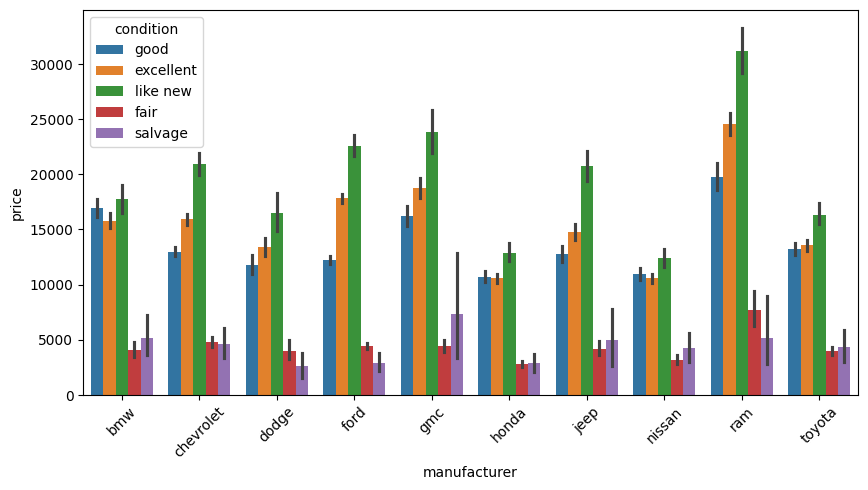

In [14]:
#Compare with condition of the vechicles
car_data['condition'].value_counts()

#Average price of the car by condition
car_condition_avg_price = car_data.groupby(['manufacturer', 'model', 'year', 'condition'])['price'].mean().reset_index()
car_condition_avg_price

#Consider only 5 types
car_condition_avg_price = car_condition_avg_price[car_condition_avg_price['condition'].isin(['good','excellent','like new','fair','salvage'])]
car_condition_avg_price['condition'] = pd.Categorical(car_condition_avg_price['condition'], categories=['good','excellent','like new','fair','salvage'], ordered=True)

#plot char with condition
plt.figure(figsize=(10,5))
sns.barplot(x='manufacturer', y='price',hue='condition',data=car_condition_avg_price)
plt.xticks(rotation=45)
plt.show()



*  New and excellent condition vechiles are higher price compare with others.



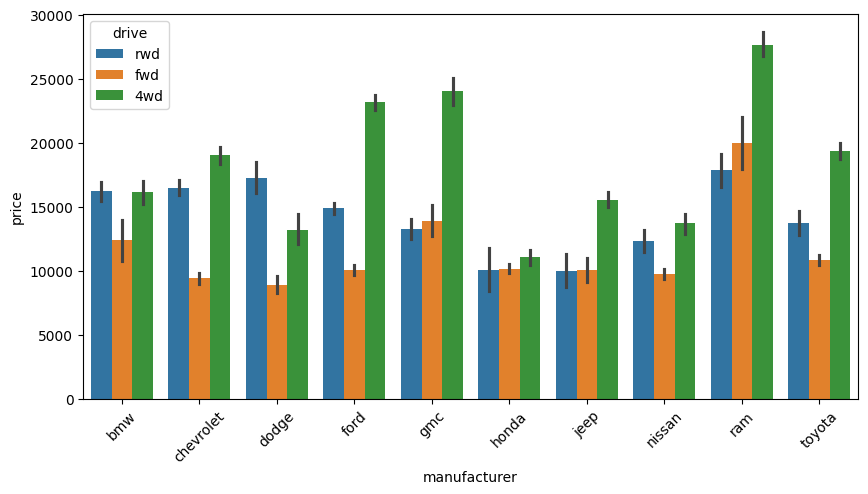

In [15]:
#compare with drive of the vechicle
car_data['drive'].value_counts()

#Average price of the car by drive
car_drive_avg_price = car_data.groupby(['manufacturer', 'model', 'year', 'drive'])['price'].mean().reset_index()
car_drive_avg_price

#plot graph with dive
plt.figure(figsize=(10,5))
sns.barplot(x='manufacturer', y='price',hue='drive',data=car_drive_avg_price)
plt.xticks(rotation=45)
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [16]:
#Remove ID,VIN number, location and paint color are not important for PCA
car_data.drop(['id','VIN','state','region','paint_color'],axis=1,inplace=True)
car_data.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck


In [17]:
#check null values
car_data.isnull().sum()

,0
price,0
year,0
manufacturer,0
model,3785
condition,122940
cylinders,111580
fuel,1938
odometer,2968
title_status,5396
transmission,1713


In [18]:
#Remove transmission
car_data.drop(['transmission'],axis=1,inplace=True)
car_data.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,drive,size,type
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,NaN,NaN,pickup
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,NaN,NaN,pickup
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,NaN,NaN,pickup
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,NaN,NaN,pickup
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,rwd,full-size,truck


In [19]:
car_data.isnull().sum()

,0
price,0
year,0
manufacturer,0
model,3785
condition,122940
cylinders,111580
fuel,1938
odometer,2968
title_status,5396
drive,77673


In [20]:
#Analyzing missing value  in the columns
car_data['cylinders'].value_counts()
car_data['fuel'].value_counts()
car_data['size'].value_counts()
car_data['type'].value_counts()


,count
type,
SUV,50520
pickup,42668
sedan,42194
truck,33041
other,12295
coupe,12238
hatchback,7269
van,6953
wagon,3905


In [21]:
#drop missing values in condition
car_data.dropna(subset=['condition'],inplace=True)
car_data.shape

(159977, 12)

In [22]:
car_data.isnull().sum()

,0
price,0
year,0
manufacturer,0
model,1585
condition,0
cylinders,36503
fuel,16
odometer,1275
title_status,3724
drive,33564


In [23]:
#drop missing values in type
car_data.dropna(subset=['type'],inplace=True)
car_data.shape

(137839, 12)

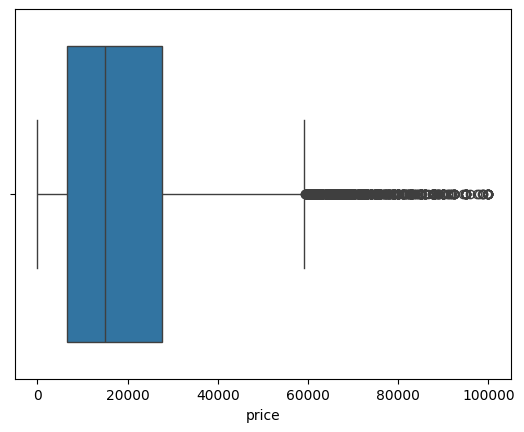

In [24]:
#checking for outliners
sns.boxplot(data=car_data, x="price")
plt.show()

In [25]:
#Remove outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    print("lower_bound",lower_bound)
    upper_bound = Q3 + 1.5 * IQR
    print("upper_bound",upper_bound)

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df


In [26]:
car_data_clean = remove_outliers_iqr(car_data, 'price')

lower_bound -25135.0
upper_bound 59225.0


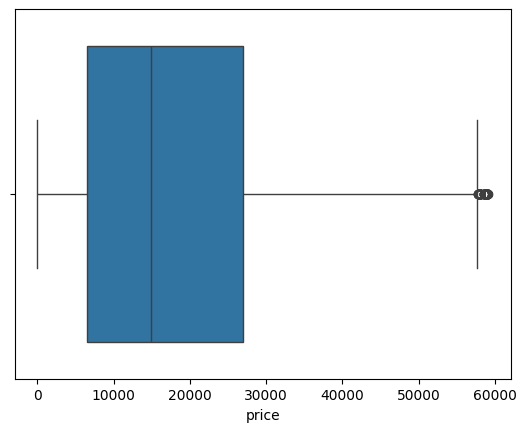

In [27]:
#checking for outliner
sns.boxplot(data=car_data_clean, x="price")
plt.show()

In [28]:
encode_car_data = car_data_clean.drop('price',axis=1)
encode_car_data.shape

(136799, 11)

In [29]:
#For categorical column
m_estimator=ce.MEstimateEncoder(cols=encode_car_data.columns)
m_estimator.fit(encode_car_data,car_data_clean['price'])
encode_car_data=m_estimator.transform(encode_car_data)


In [30]:
target_encode=ce.TargetEncoder(cols=encode_car_data.columns)
target_encode.fit(encode_car_data,car_data_clean['price'])
encode_car_data=target_encode.transform(encode_car_data)

In [31]:
encode_car_data['price'] = car_data_clean['price']
print(encode_car_data.shape)
print(type(encode_car_data))
print(encode_car_data.columns)

(136799, 12)
<class 'pandas.core.frame.DataFrame'>
Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type', 'price'],
      dtype='object')


In [32]:
#features and target
target = encode_car_data['price']
#features = encode_car_data.drop('price',axis=1)
scaler = StandardScaler()
encode_car_data[encode_car_data.columns] = scaler.fit_transform(encode_car_data[encode_car_data.columns])
#


In [33]:
highest_corr = encode_car_data.corr()[['price']].nlargest(columns = 'price', n = 2).index[1]
print("highest correlation:",highest_corr)

highest correlation: odometer


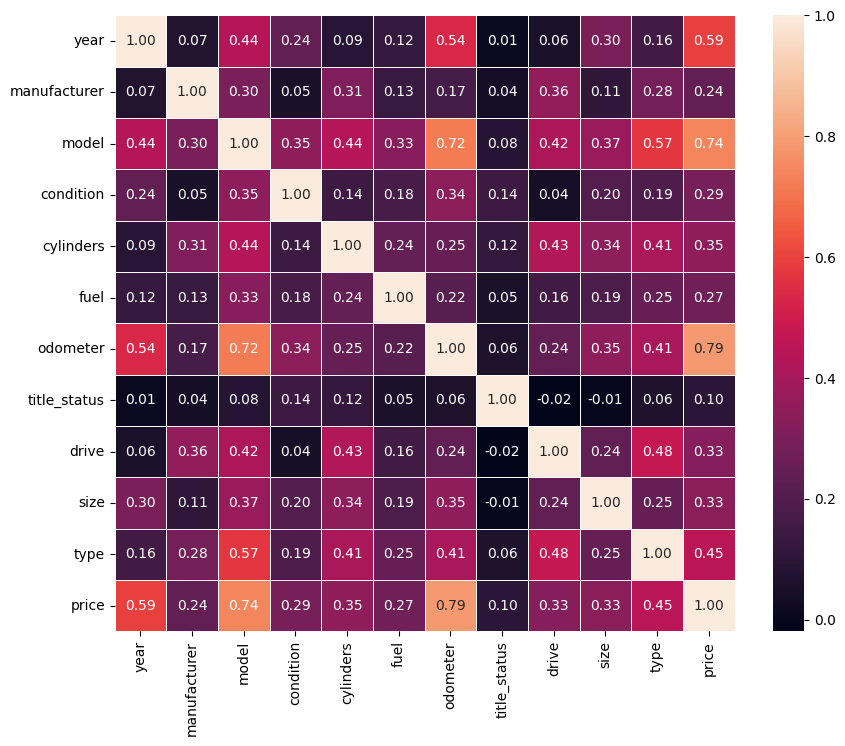

In [34]:
#visualize correction matrix
corr_matrix = encode_car_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True,fmt='.2f',linewidths=.5)
plt.show()

In [35]:
pca_3d=PCA(n_components=3)
x_pca=pca_3d.fit_transform(encode_car_data)

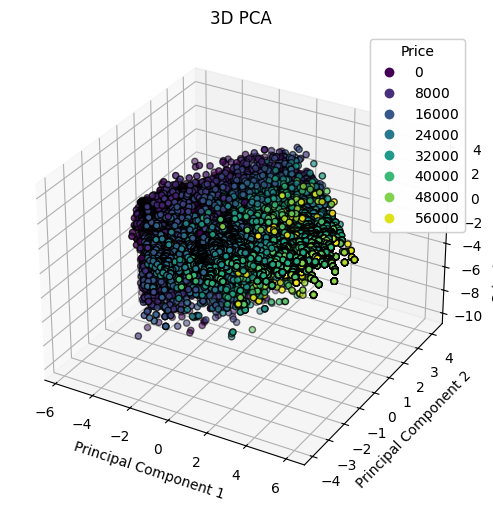

In [36]:
#visualize with plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=target, cmap='viridis', edgecolor='k')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA')
legend1 = ax.legend(*scatter.legend_elements(), title='Price')
ax.add_artist(legend1)
plt.show()

In [37]:
#pca to 2 dimensions
pca_2d = PCA(n_components=2)
x_pca_2d = pca_2d.fit_transform(encode_car_data)

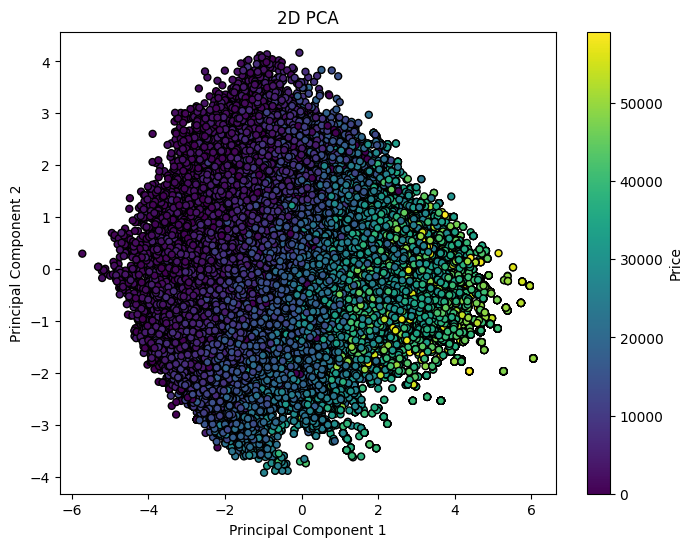

In [38]:
#plot in 2D with Matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(x_pca_2d[:, 0], x_pca_2d[:, 1], c=target, cmap='viridis', edgecolor='k', s=25)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA')
plt.colorbar(label='Price')
plt.show()

In [39]:
#check variance
variance=encode_car_data.var
print(variance)

<bound method DataFrame.var of             year  manufacturer     model  condition  cylinders      fuel  \
27      0.215351      1.465913  1.986799   0.878297   0.861333 -0.367034   
28     -0.809613      0.178523  0.084367   0.878297   0.861333 -0.367034   
29      1.860812      0.178523  1.886659   0.878297   0.861333 -0.367034   
30      0.905332     -0.365175  1.933524   0.878297   0.861333 -0.367034   
31     -0.127770     -0.022175  0.101982  -0.792779  -0.086471 -0.367034   
...          ...           ...       ...        ...        ...       ...   
426836  1.218755      2.263818  0.351009  -0.792779  -0.086471  2.350386   
426857  1.526513     -0.365175  2.340033   0.878297  -0.086471 -0.367034   
426864  0.685492     -0.365175  1.804751   0.878297  -0.086471 -0.367034   
426875  1.526513     -1.461783  0.394910   0.878297  -0.086471 -0.367034   
426879  1.526513      1.214871  0.851604   0.878297   0.778951 -0.367034   

        odometer  title_status     drive      size      

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [40]:
target_feature = 'price'
car_data_clean = car_data_clean.fillna('missing')
X = car_data_clean.drop('price', axis=1)
y = encode_car_data['price']
#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
#for cat in categorical_columns:
ml_estimator = ce.MEstimateEncoder(cols=X_train.columns)
mestimator_linear_pipeline = Pipeline([
    ('mtransformer', ml_estimator),
    ('mscalor',StandardScaler()),
    ('mlinreg', LinearRegression())])
mestimator_linear_pipeline

Pipeline(steps=[('mtransformer',
                 MEstimateEncoder(cols=Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type'],
      dtype='object'))),
                ('mscalor', StandardScaler()),
                ('mlinreg', LinearRegression())])

In [42]:
#for cat in categorical_columns:
mr_estimator = ce.MEstimateEncoder(cols=X_train.columns)
mestimator_ridge_pipeline = Pipeline([
    ('mtransformer', mr_estimator),
    ('mscalor',StandardScaler()),
    ('mlinreg', Ridge())])
mestimator_ridge_pipeline

Pipeline(steps=[('mtransformer',
                 MEstimateEncoder(cols=Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type'],
      dtype='object'))),
                ('mscalor', StandardScaler()), ('mlinreg', Ridge())])

In [43]:
#for cat in categorical_columns:
js_estimator = ce.JamesSteinEncoder(cols=X_train.columns)
jestimator_linear_pipeline = Pipeline([
    ('mtransformer', js_estimator),
    ('mscalor',StandardScaler()),
    ('mlinreg', LinearRegression())])
jestimator_linear_pipeline

Pipeline(steps=[('mtransformer',
                 JamesSteinEncoder(cols=Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type'],
      dtype='object'))),
                ('mscalor', StandardScaler()),
                ('mlinreg', LinearRegression())])

In [44]:
#for cat in categorical_columns:
jsr_estimator = ce.JamesSteinEncoder(cols=X_train.columns)
jestimator_ridge_pipeline = Pipeline([
    ('mtransformer', jsr_estimator),
    ('mscalor',StandardScaler()),
    ('mlinreg', Ridge())])
jestimator_ridge_pipeline

Pipeline(steps=[('mtransformer',
                 JamesSteinEncoder(cols=Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type'],
      dtype='object'))),
                ('mscalor', StandardScaler()), ('mlinreg', Ridge())])

In [45]:
#for cat in categorical_columns:
cb_estimator = ce.CatBoostEncoder(cols=X_train.columns)
cbestimator_linear_pipeline = Pipeline([
    ('mtransformer', cb_estimator),
    ('mscalor',StandardScaler()),
    ('mlinreg', LinearRegression())])
cbestimator_linear_pipeline

Pipeline(steps=[('mtransformer',
                 CatBoostEncoder(cols=Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type'],
      dtype='object'))),
                ('mscalor', StandardScaler()),
                ('mlinreg', LinearRegression())])

In [46]:
#for cat in categorical_columns:
cb_estimator = ce.CatBoostEncoder(cols=X_train.columns)
cbestimator_ridge_pipeline = Pipeline([
    ('mtransformer', cb_estimator),
    ('mscalor',StandardScaler()),
    ('mlinreg', Ridge())])
cbestimator_ridge_pipeline

Pipeline(steps=[('mtransformer',
                 CatBoostEncoder(cols=Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'size', 'type'],
      dtype='object'))),
                ('mscalor', StandardScaler()), ('mlinreg', Ridge())])

In [47]:
results = pd.DataFrame(columns=['loss','MEstimator_Linear','MEstimator_Ridge','JStein_Linear','JStein_Ridge','CBoost_Linear','CBoost_Ridge'])
results['loss']=['MSE_Train','MSE_Test','MAE_Train','MAE_Test','R2_Train','R2_Test']
results = results.set_index('loss')
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,NaN,NaN,NaN,NaN,NaN,NaN
MSE_Test,NaN,NaN,NaN,NaN,NaN,NaN
MAE_Train,NaN,NaN,NaN,NaN,NaN,NaN
MAE_Test,NaN,NaN,NaN,NaN,NaN,NaN
R2_Train,NaN,NaN,NaN,NaN,NaN,NaN
R2_Test,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
mestimator_linear_pipeline.fit(X_train,y_train)
y_train_pred = mestimator_linear_pipeline.predict(X_train)
y_test_pred = mestimator_linear_pipeline.predict(X_test)
train_mse = float(mean_squared_error(y_train,y_train_pred))
test_mse = float(mean_squared_error(y_test,y_test_pred))
train_mae = float(mean_absolute_error(y_train,y_train_pred))
test_mae = float(mean_absolute_error(y_test,y_test_pred))

# Compute R² using Scikit-Learn
R2_test = r2_score(y_test, y_test_pred)
R2_train = r2_score(y_train, y_train_pred)
results['MEstimator_Linear']=[train_mse,test_mse,train_mae,test_mae,R2_test,R2_train]
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,0.180457,NaN,NaN,NaN,NaN,NaN
MSE_Test,0.310237,NaN,NaN,NaN,NaN,NaN
MAE_Train,0.279282,NaN,NaN,NaN,NaN,NaN
MAE_Test,0.371931,NaN,NaN,NaN,NaN,NaN
R2_Train,0.690109,NaN,NaN,NaN,NaN,NaN
R2_Test,0.819489,NaN,NaN,NaN,NaN,NaN


In [49]:
mestimator_ridge_pipeline.fit(X_train,y_train)
y_train_pred = mestimator_ridge_pipeline.predict(X_train)
y_test_pred = mestimator_ridge_pipeline.predict(X_test)
train_mse = float(mean_squared_error(y_train,y_train_pred))
test_mse = float(mean_squared_error(y_test,y_test_pred))
train_mae = float(mean_absolute_error(y_train,y_train_pred))
test_mae = float(mean_absolute_error(y_test,y_test_pred))

# Compute R² using Scikit-Learn
R2_test = r2_score(y_test, y_test_pred)
R2_train = r2_score(y_train, y_train_pred)
results['MEstimator_Ridge']=[train_mse,test_mse,train_mae,test_mae,R2_test,R2_train]
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,0.180457,0.180457,NaN,NaN,NaN,NaN
MSE_Test,0.310237,0.310235,NaN,NaN,NaN,NaN
MAE_Train,0.279282,0.279282,NaN,NaN,NaN,NaN
MAE_Test,0.371931,0.371929,NaN,NaN,NaN,NaN
R2_Train,0.690109,0.690112,NaN,NaN,NaN,NaN
R2_Test,0.819489,0.819489,NaN,NaN,NaN,NaN


In [50]:
jestimator_linear_pipeline.fit(X_train,y_train)
y_train_pred = jestimator_linear_pipeline.predict(X_train)
y_test_pred = jestimator_linear_pipeline.predict(X_test)
train_mse = float(mean_squared_error(y_train,y_train_pred))
test_mse = float(mean_squared_error(y_test,y_test_pred))
train_mae = float(mean_absolute_error(y_train,y_train_pred))
test_mae = float(mean_absolute_error(y_test,y_test_pred))

# Compute R² using Scikit-Learn
R2_test = r2_score(y_test, y_test_pred)
R2_train = r2_score(y_train, y_train_pred)
results['JStein_Linear']=[train_mse,test_mse,train_mae,test_mae,R2_test,R2_train]
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,0.180457,0.180457,0.154390,NaN,NaN,NaN
MSE_Test,0.310237,0.310235,0.311657,NaN,NaN,NaN
MAE_Train,0.279282,0.279282,0.242243,NaN,NaN,NaN
MAE_Test,0.371931,0.371929,0.361770,NaN,NaN,NaN
R2_Train,0.690109,0.690112,0.688691,NaN,NaN,NaN
R2_Test,0.819489,0.819489,0.845564,NaN,NaN,NaN


In [51]:
jestimator_ridge_pipeline.fit(X_train,y_train)
y_train_pred = jestimator_ridge_pipeline.predict(X_train)
y_test_pred = jestimator_ridge_pipeline.predict(X_test)
train_mse = float(mean_squared_error(y_train,y_train_pred))
test_mse = float(mean_squared_error(y_test,y_test_pred))
train_mae = float(mean_absolute_error(y_train,y_train_pred))
test_mae = float(mean_absolute_error(y_test,y_test_pred))

# Compute R² using Scikit-Learn
R2_test = r2_score(y_test, y_test_pred)
R2_train = r2_score(y_train, y_train_pred)
results['JStein_Ridge']=[train_mse,test_mse,train_mae,test_mae,R2_test,R2_train]
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,0.180457,0.180457,0.154390,0.154390,NaN,NaN
MSE_Test,0.310237,0.310235,0.311657,0.311655,NaN,NaN
MAE_Train,0.279282,0.279282,0.242243,0.242243,NaN,NaN
MAE_Test,0.371931,0.371929,0.361770,0.361769,NaN,NaN
R2_Train,0.690109,0.690112,0.688691,0.688693,NaN,NaN
R2_Test,0.819489,0.819489,0.845564,0.845564,NaN,NaN


In [52]:
cbestimator_linear_pipeline.fit(X_train,y_train)
y_train_pred = cbestimator_linear_pipeline.predict(X_train)
y_test_pred = cbestimator_linear_pipeline.predict(X_test)
train_mse = float(mean_squared_error(y_train,y_train_pred))
test_mse = float(mean_squared_error(y_test,y_test_pred))
train_mae = float(mean_absolute_error(y_train,y_train_pred))
test_mae = float(mean_absolute_error(y_test,y_test_pred))

# Compute R² using Scikit-Learn
R2_test = r2_score(y_test, y_test_pred)
R2_train = r2_score(y_train, y_train_pred)
results['CBoost_Linear']=[train_mse,test_mse,train_mae,test_mae,R2_test,R2_train]
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,0.180457,0.180457,0.154390,0.154390,0.265223,NaN
MSE_Test,0.310237,0.310235,0.311657,0.311655,0.306829,NaN
MAE_Train,0.279282,0.279282,0.242243,0.242243,0.349791,NaN
MAE_Test,0.371931,0.371929,0.361770,0.361769,0.372531,NaN
R2_Train,0.690109,0.690112,0.688691,0.688693,0.693514,NaN
R2_Test,0.819489,0.819489,0.845564,0.845564,0.734698,NaN


In [53]:
cbestimator_ridge_pipeline.fit(X_train,y_train)
y_train_pred = cbestimator_ridge_pipeline.predict(X_train)
y_test_pred = cbestimator_ridge_pipeline.predict(X_test)
train_mse = float(mean_squared_error(y_train,y_train_pred))
test_mse = float(mean_squared_error(y_test,y_test_pred))
train_mae = float(mean_absolute_error(y_train,y_train_pred))
test_mae = float(mean_absolute_error(y_test,y_test_pred))

# Compute R² using Scikit-Learn
R2_test = r2_score(y_test, y_test_pred)
R2_train = r2_score(y_train, y_train_pred)
results['CBoost_Ridge']=[train_mse,test_mse,train_mae,test_mae,R2_test,R2_train]
results.head(6)

,MEstimator_Linear,MEstimator_Ridge,JStein_Linear,JStein_Ridge,CBoost_Linear,CBoost_Ridge
loss,,,,,,
MSE_Train,0.180457,0.180457,0.154390,0.154390,0.265223,0.265223
MSE_Test,0.310237,0.310235,0.311657,0.311655,0.306829,0.306829
MAE_Train,0.279282,0.279282,0.242243,0.242243,0.349791,0.349790
MAE_Test,0.371931,0.371929,0.361770,0.361769,0.372531,0.372531
R2_Train,0.690109,0.690112,0.688691,0.688693,0.693514,0.693514
R2_Test,0.819489,0.819489,0.845564,0.845564,0.734698,0.734698


In [54]:
# Calculate permutation importance
result = permutation_importance(mestimator_ridge_pipeline, X_test, y_test,n_repeats=10)
result

{'importances_mean': array([4.24624682e-02, 1.02058580e-03, 9.06045928e-02, 1.64916140e-03,
        6.95421204e-03, 1.48333178e-03, 6.64199234e-01, 1.26539969e-03,
        7.03527465e-03, 4.87344385e-04, 5.34679620e-04]),
 'importances_std': array([8.27399114e-04, 4.97504084e-05, 1.30596799e-03, 1.84089016e-04,
        2.57080744e-04, 1.07694797e-04, 5.49001806e-03, 1.40449931e-04,
        1.75957256e-04, 2.10736634e-04, 3.57507189e-05]),
 'importances': array([[4.25108307e-02, 4.12767481e-02, 4.17960150e-02, 4.21967124e-02,
         4.32967902e-02, 4.31960938e-02, 4.35445296e-02, 4.20665371e-02,
         4.12876473e-02, 4.34527781e-02],
        [9.57290280e-04, 1.00291313e-03, 1.00062753e-03, 1.04018743e-03,
         1.01677317e-03, 1.00759506e-03, 9.63656543e-04, 1.08701216e-03,
         1.00211046e-03, 1.12769226e-03],
        [8.91520184e-02, 8.96557190e-02, 9.24329352e-02, 8.91554317e-02,
         9.18928871e-02, 9.13171129e-02, 9.17413961e-02, 8.86998568e-02,
         9.02237235e

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [58]:
# Create a DataFrame for feature importances
importances = pd.DataFrame({'feature': X_test.columns, 'importance': result.importances_mean})

# Visualize feature importances using plotly.express
px.bar(data_frame=importances, x='importance', y='feature', orientation='h', title='Feature importance for price prediction')

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.